# Emotion Analysis by Subtheme per Agreement level

This notebook shows the emotion of a comment. Comments can be viewed individually as well aggregated to the subtheme and theme level. The comments can have the emotions: anger, fear, and sadness.

To determine the emotion of a comment the lexicon NRC Affect Intensity Lexicon v0.5 (Saif M. Mohammad) was used. This lexicon consists of words with a score from 0 to 1 associated with an emotion where the higher the scores indicates the word is more strongly associated with that emotion. To get the overall emotion of the comment the scores from each word are summed and the emotion with the highest score is associated with the comment.  To be able to compare the scores from one comment to another to determine the angriest, saddest and most fearful comments the scores were divided by the **total number of words**. 

The lexicon does contain joy as an emotion but joy was left out of this analysis since the comments should be predominately negative and we are trying to determine the negative emotion driving these comments. Joy was included at first but removed as it was found to be the most common emotion due to the words associated with joy are more common but they are predominately being used with a negative connotation like this example where "good" is the associated joy word but it was being used as "not good". Since this only looks at matching words it does not pick up on how the word is used. When examples of anger, fear and sadness were looked at the words were being used in the appropriate manner for this analysis. 

### Instructions for use

This notebook can be used to look at different emotions, comments, subthemes and themes. Change the parameters of the functions to look at different examples. 


In [1]:
# Required packages
import pandas as pd
import numpy as np
import time

import spacy
# Load English model for SpaCy
nlp = spacy.load('en_core_web_sm')

In [2]:
# Change working directory to be project root, by removing the # and running `os.chdir("..")` once then comment out.
import os
#os.chdir("..")
os.getcwd()

'C:\\Users\\payla\\Documents\\MDS\\Capstone\\DSCI_591_capstone-BCStats'

In [3]:
# remove once notebook is finished
# ensure packages reload after every change 

%load_ext autoreload
%autoreload 2
import src

from src.emotion_analysis import *

## Load Data and Lexicon

In [10]:
# read agreement data
data_full = pd.read_csv(".\data\interim\desensitized_qualitative-data2018.csv",
                            usecols=[0, 1, 2, 3, 4, 5, 6], 
                            names=["USERID", "text", "code1", "code2", "code3", "code4", "code5"], skiprows=1)

# read agreement data
data_agreement = pd.read_csv(".\data\interim\joined_qual_quant.csv",
                            usecols=[0, 1, 5, 6])

# load lexicon
lexicon = pd.read_csv("http://saifmohammad.com/WebDocs/NRC-AffectIntensity-Lexicon.txt", 
                      sep="\t", 
                      skiprows=35) 
# read in data legend
legend = pd.read_csv("./references/data-dictionaries/theme_subtheme_names.csv")

In [11]:
display(data_full.head(3))
display(data_agreement.head(3))
display(lexicon.head(3))
display(legend.head(3))

,USERID,text,code1,code2,code3,code4,code5
0,192723-544650,I would suggest having a developmental growth ...,62,13,NaN,NaN,NaN
1,188281-540434,Base decisions regarding fish and wildlife on ...,116,NaN,NaN,NaN,NaN
2,191202-862188,"Improved office space (fix HVAC, etc) but NO LWS",102,51,NaN,NaN,NaN


,USERID,code,diff,text
0,175125-215928,43,0,The problem with the BCSS is Linda Cavanaugh a...
1,175125-215928,43,0,The problem with the BCSS is Linda Cavanaugh a...
2,191202-862188,102,0,"Improved office space (fix HVAC, etc) but NO LWS"


,term,score,AffectDimension
0,outraged,0.964,anger
1,brutality,0.959,anger
2,hatred,0.953,anger


,theme,code,subtheme_description
0,Career & Personal Development,11,Improve new employee orientation
1,Career & Personal Development,12,Improve performance management process
2,Career & Personal Development,13,Improve training and development opportunities


## Add Process Full Comment data and Add Themes Names

In [12]:
data_full = src.emotion_analysis.format_raw_comments(data_full)

In [13]:
data_full = src.emotion_analysis.get_theme_labels(data_full, legend)
data_agreement = src.emotion_analysis.get_theme_labels(data_agreement, legend)

In [14]:
display(data_full.head(3))
display(data_agreement.head(3))

,USERID,code,text,theme,subtheme_description
0,192723-544650,62,I would suggest having a developmental growth ...,Staffing Practices,Focus on Human Resources planning (recruitment...
1,188281-540434,116,Base decisions regarding fish and wildlife on ...,"Vision, Mission & Goals",Reduce political influence
2,191202-862188,102,"Improved office space (fix HVAC, etc) but NO LWS","Tools, Equipment & Physical Environment","Improve facilities (e.g. office space, noise l..."


,USERID,code,diff,text,theme,subtheme_description
0,175125-215928,43,0,The problem with the BCSS is Linda Cavanaugh a...,Executives,Strengthen quality of executive leadership
1,175125-215928,43,0,The problem with the BCSS is Linda Cavanaugh a...,Executives,Strengthen quality of executive leadership
2,191202-862188,102,0,"Improved office space (fix HVAC, etc) but NO LWS","Tools, Equipment & Physical Environment","Improve facilities (e.g. office space, noise l..."


## Obtain Emotion Scores for Each Comment

In [15]:
start = time.time()
full_scores = src.emotion_analysis.obtain_emotion_scores(data_full, lexicon, anger=True, fear=True, sadness=True, joy=False)
end = time.time()
print((end - start) / 60, "mins")

7.3161325852076216 mins


In [16]:
start = time.time()
agreement_scores = src.emotion_analysis.obtain_emotion_scores(data_agreement, 
                                                              lexicon, 
                                                              anger=True, fear=True, sadness=True, joy=False)
end = time.time()
print((end - start) / 60, "mins")

9.438365157445272 mins


In [17]:
display(full_scores.head(3))
display(agreement_scores.head(3))

,USERID,code,text,theme,subtheme_description,anger,fear,sad
0,192723-544650,62,i would suggest having a developmental growth ...,Staffing Practices,Focus on Human Resources planning (recruitment...,0.0,0.0,0.0
1,188281-540434,116,base decisions regarding fish and wildlife on ...,"Vision, Mission & Goals",Reduce political influence,0.0,0.0,0.0
2,191202-862188,102,"improved office space (fix hvac, etc) but no lws","Tools, Equipment & Physical Environment","Improve facilities (e.g. office space, noise l...",0.0,0.0,0.0


,USERID,code,diff,text,theme,subtheme_description,anger,fear,sad
0,175125-215928,43,0,the problem with the bcss is linda cavanaugh a...,Executives,Strengthen quality of executive leadership,1.851,2.478,2.578
1,175125-215928,43,0,the problem with the bcss is linda cavanaugh a...,Executives,Strengthen quality of executive leadership,1.851,2.478,2.578
2,191202-862188,102,0,"improved office space (fix hvac, etc) but no lws","Tools, Equipment & Physical Environment","Improve facilities (e.g. office space, noise l...",0.000,0.000,0.000


### Overall Emotions

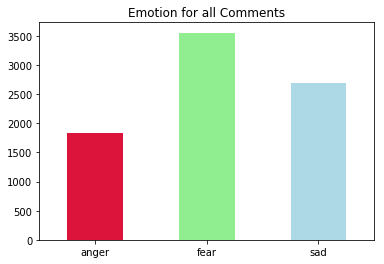

In [21]:
src.emotion_analysis.plot_data(data=full_scores)

In [112]:
a = src.emotion_analysis.display_top_emotions(full_scores, "fear", 5, normalize=False)
a

,code,text,theme,subtheme_description,anger,fear,sad
10000,83,to not be afraid to truly blend with the staff...,Supervisors,Strengthen quality of supervisory leadership,4.366,6.610,2.548
9778,101,staffing levels. there is far too much violenc...,"Tools, Equipment & Physical Environment",Ensure safety and security of employees,4.054,6.573,5.534
12468,113,the trauma informed model does not work as a m...,"Vision, Mission & Goals",Improve program and/or policy implementation,1.836,6.327,1.031
14115,113,we have gotten to a point where the rights of ...,"Vision, Mission & Goals",Improve program and/or policy implementation,1.560,5.917,2.365
4610,94,as being part of a ministry that has a high le...,Stress & Workload,Support a healthy workplace,1.621,5.743,4.458


In [206]:
src.emotion_analysis.examine_emotion_scoring_randomized(full_scores, "fear", lexicon, 9778 )

,code,text,theme,subtheme_description,anger,fear,sad,_anger,_fear,_sad
9778,101,staffing levels. there is far too much violenc...,"Tools, Equipment & Physical Environment",Ensure safety and security of employees,4.054,6.573,5.534,0,1,0




Comment
-------
staffing levels. there is far too much violence against staff, particularly recently, to justify 40 or 60 or 72 to 1 inmate/staff ratios. i understand that staff retention is a problem but when we are paid $28000 less than our federal counterparts and less than half of other law enforcement agencies (some policing i.e. delta $120k ) with higher frequency of violence how can you expect applicants to stay. i hate watching my co-workers get hurt over and over again with no change. there are so many factors that apply to that statement but hiring people with no life experience because we do not pay a living wage for new hires. something has to give and cause change, and i hope its not a correctional officer suffering a fatal injury.  


ANGER
-----
violence 0.742
violence 0.742
hate 0.828
hurt 0.561
fatal 0.712
injury 0.469


FEAR
-----
violence 0.812
inmate 0.469
problem 0.266
less 0.167
less 0.167
violence 0.812
hate 0.484
hurt 0.688
change 0.198
change 0.198
suffering 

In [208]:
# total number of comments is higher because there are duplicates 
# since comments relate to multiple mc questions
src.emotion_analysis.summary_number_comment(full_scores, 0.3, include=True)
src.emotion_analysis.summary_number_comment(df, 0.5)
src.emotion_analysis.summary_number_comment(df, 1)
src.emotion_analysis.summary_number_comment(df, 2)
src.emotion_analysis.summary_number_comment(df, 5)

KeyError: "['joy'] not in index"

### Observations from subtheme level analysis

- joy is the most common emotion for all subthemes and agreement levels 
  - this seems to be due to the only words in the comment being happy
      - might be worth aggregating all of the sentences together and then doing the comparison
  - the other main reseson is the words are just with a negative context and since this is only matching words it doesn't understand the meaning
      - might be worth removing joy all together because it doesn't really match well
      
- a good set of the comments match to the emotion
    - Could manually score a small set of them to get an "accuracy" score
    - bit of weirdness due to context, government is one of the words in the lexicon and it is being used as a name compared to an emotion. Same with words like leave since it relates to time off not leaving often

- there are over 5000 comments that have no related emotion

- this seems counterintuitive
- subtheme 35, 82, 105
  - anger as dominant as joy in no agreement 
  - not since I made the adjustment to remove the emotionless comments
- subtheme 42, 101
  - fear is dominant as fear in strong agreement 
  